### Imports and load data

In [68]:
# This magic command plots figures directly in the notebook
%matplotlib inline
# This sets a higher resolution for figures
%config InlineBackend.figure_format = 'retina'

import os 
import numpy as np
import pickle
import matplotlib.pyplot as plt
from sklearn import linear_model
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering


import mglearn

In [69]:
# Set directory in which the data structure can be found
os.chdir(r'C:\Users\jaapv\Desktop\master\VoytekLab')

# data
datastruct = np.load('datastruct_full.npy',  allow_pickle=True)

# dataframe
features_df = pd.read_csv('features_df.csv', sep=',')

### Correlation Matrix

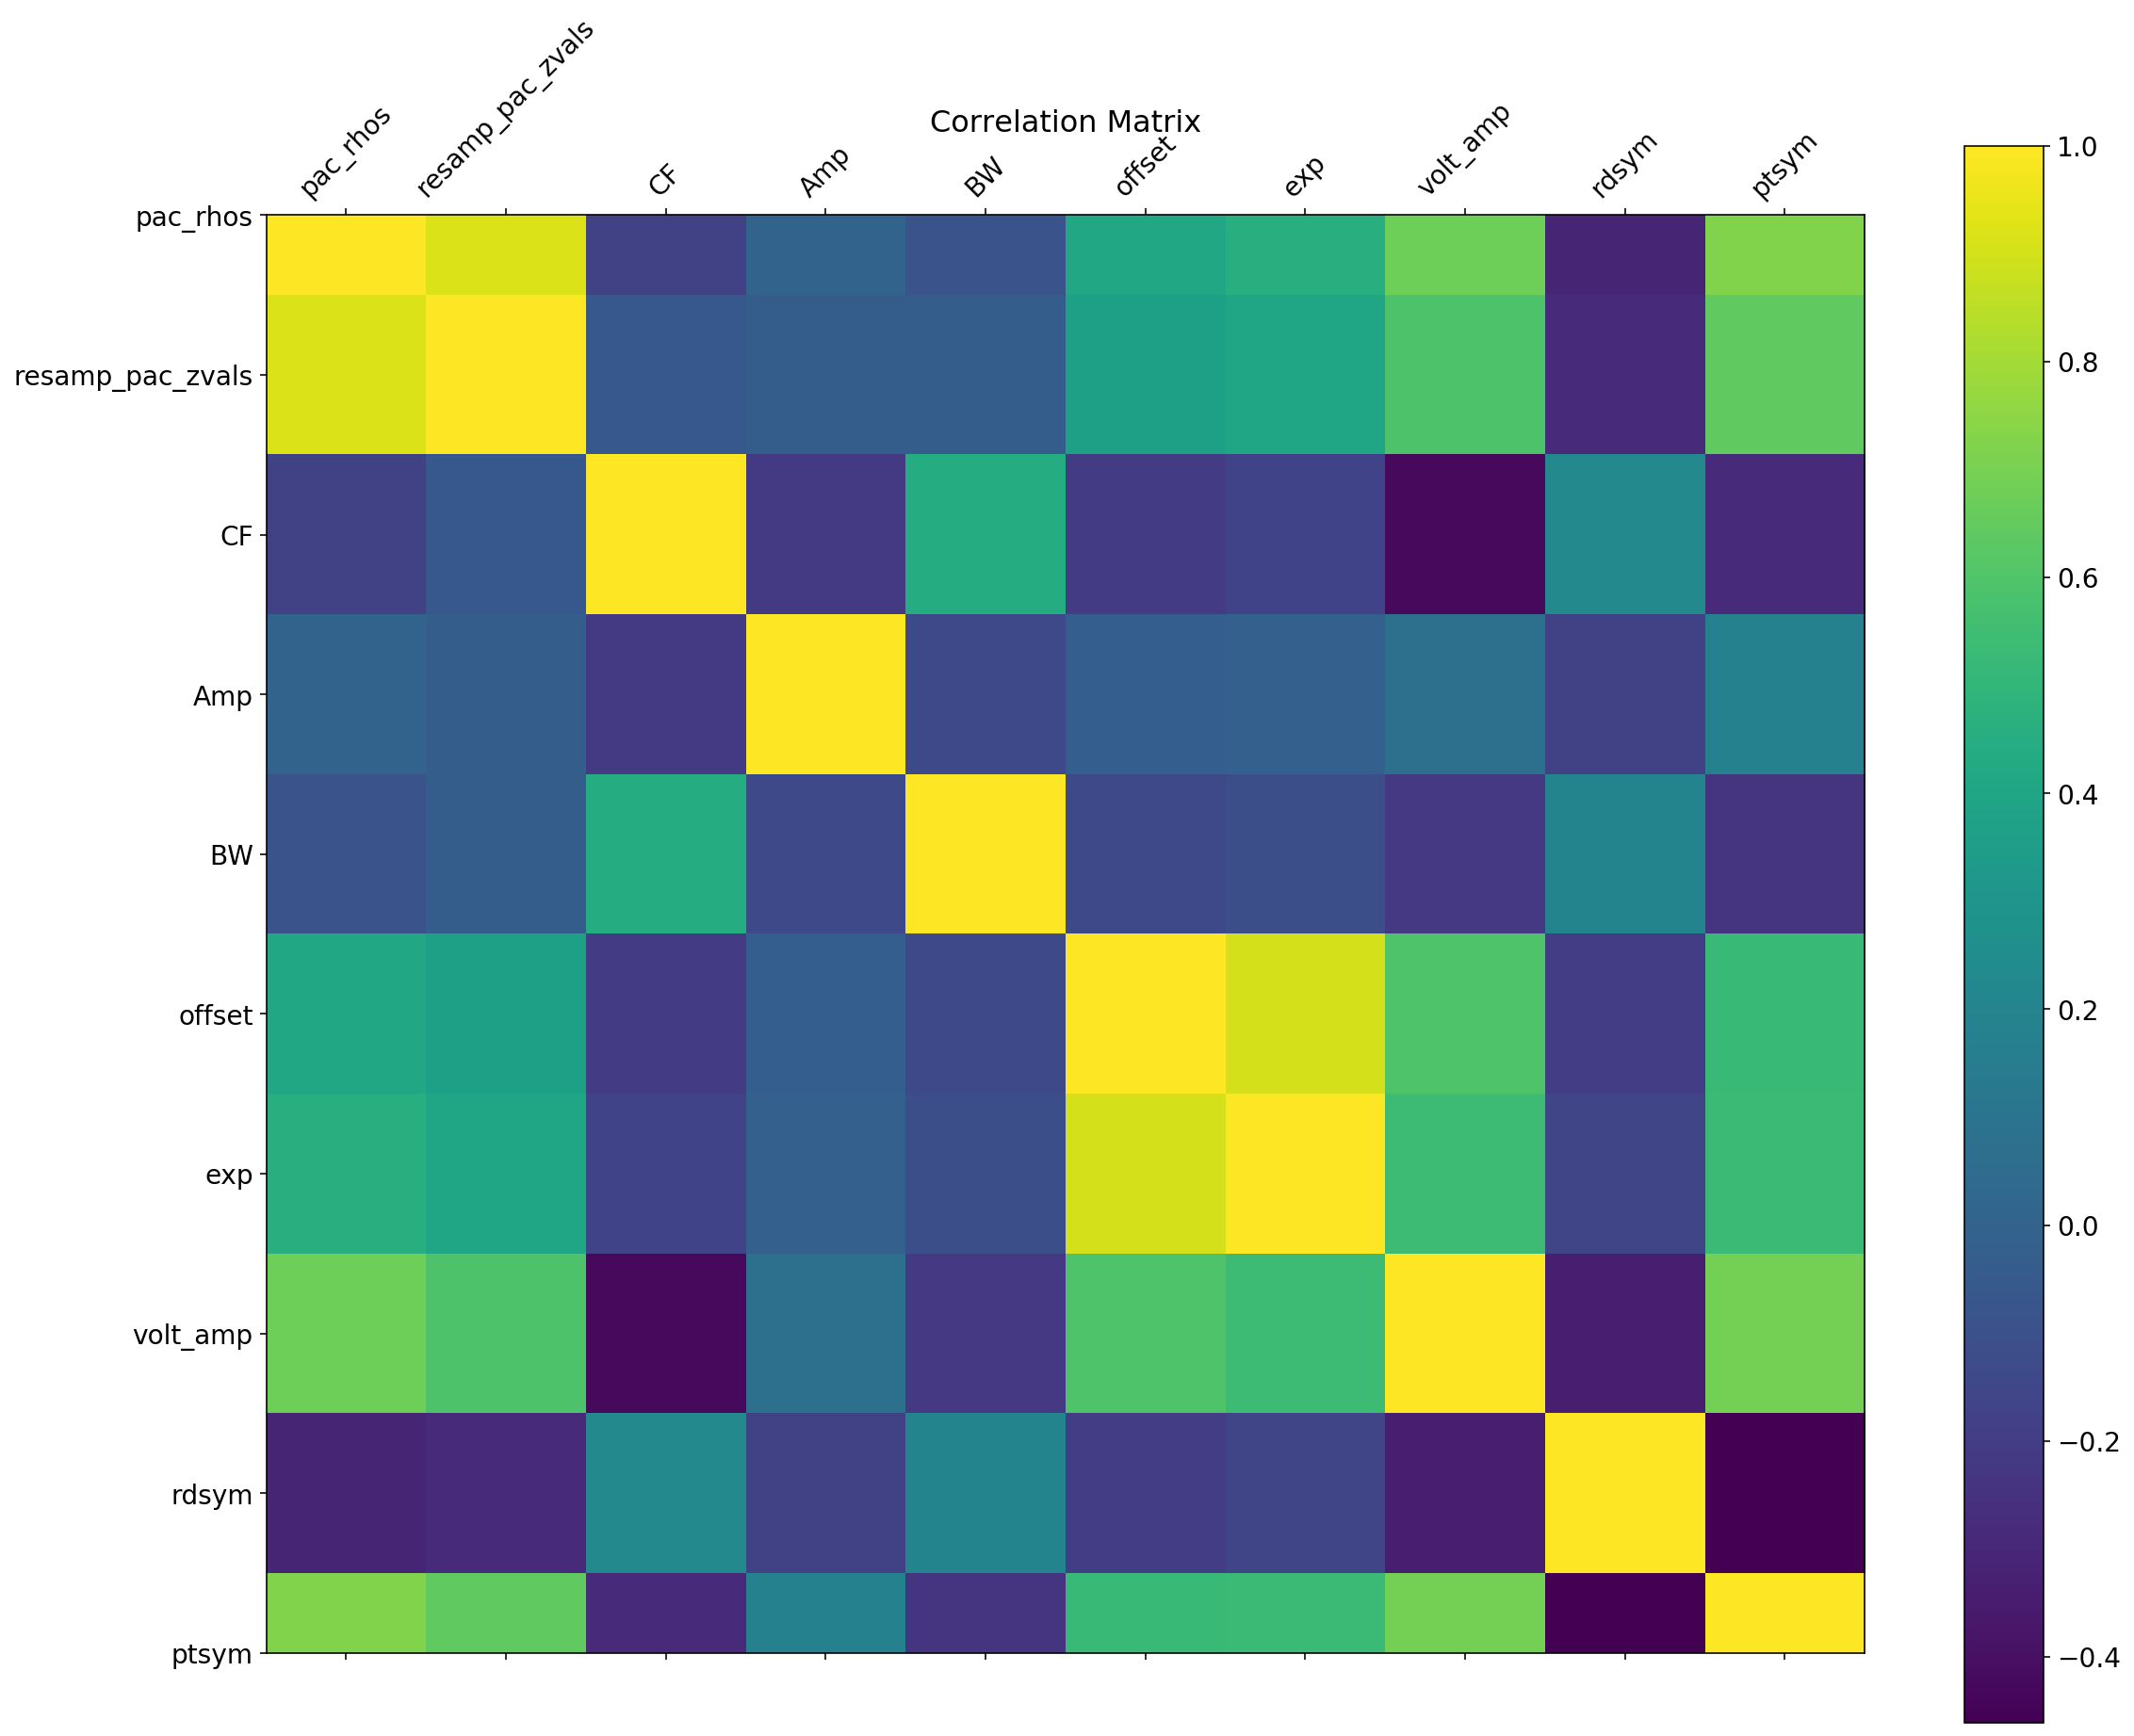

In [70]:
# first create new dataframe with only the features we want to plot
corr_features_df = features_df[['pac_rhos', 'resamp_pac_zvals','CF', 'Amp', 'BW', 'offset', 'exp',
                                'volt_amp', 'rdsym', 'ptsym']].copy()

f = plt.figure(figsize=(19, 15))
plt.matshow(corr_features_df.corr(), fignum=f.number)
plt.xticks(range(corr_features_df.shape[1]), corr_features_df.columns, fontsize=14, rotation=45)
plt.yticks(range(corr_features_df.shape[1]), corr_features_df.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);


 <div class="alert alert-danger">
Both measures of the PAC value and two of the background parameters correlate too much with each other, so we standardize them and add them.
</div>

In [71]:
# change to right shape for sklearn

# change shape of the PAC measurements
pac_rhos = np.reshape(features_df[['pac_rhos']].copy(), [len(features_df['pac_rhos']), 1])
resamp_pac_zvals = np.reshape(features_df[['resamp_pac_zvals']].copy(), [len(features_df['resamp_pac_zvals']), 1])

# change shape of the aperiodic slope measurement
offset = np.reshape(features_df[['offset']].copy(), [len(features_df['offset']), 1])
exp = np.reshape(features_df[['exp']].copy(), [len(features_df['exp']), 1])

# change shape of the aperiodic slope measurement
offset_long = np.reshape(features_df[['offset_long']].copy(), [len(features_df['offset_long']), 1])
exp_long = np.reshape(features_df[['exp_long']].copy(), [len(features_df['exp_long']), 1])

# first scale both data and then add them

# for PAC values
scaler = StandardScaler()
pac_values = scaler.fit_transform(pac_rhos) + scaler.fit_transform(resamp_pac_zvals)

# for slope
slope = scaler.fit_transform(offset) + scaler.fit_transform(exp)

# for slope (long measure)
slope_long = scaler.fit_transform(offset_long) + scaler.fit_transform(exp_long)

# write all three new features to the features_df 
features_df['pac_values'] = pac_values
features_df['slope'] = slope
features_df['slope_long'] = slope_long

In [81]:
# first drop all nan's (which are the channels with no true oscillation < 30 Hz)
features_df_nonan = features_df.dropna()

# stack the PAC values, periodic features, and the waveform shape features into 1 SKLearn shape
cluster_features = np.hstack((
                   features_df_nonan[['pac_values']].copy(), features_df_nonan[['CF']].copy(), 
                   features_df_nonan[['Amp']].copy(), features_df_nonan[['BW']].copy(), 
                   features_df_nonan[['volt_amp']].copy(), features_df_nonan[['rdsym']].copy(), 
                   features_df_nonan[['ptsym']].copy())) 

# Scale all data 
scaler = StandardScaler()
scaler.fit(cluster_features)
X_scaled = scaler.transform(cluster_features)

# 2. Clustering with K-Means Analysis + Principal Component Analysis

Because the true and spurious PAC both have different origins (true interactions versus non-sinusoidal features), we expect these types of PAC differ on at least some of the features. Therefore, we use the unsupervised K-Means machine learning method. For visualization purposes we do a Principal Component Analysis for dimensionality reduction so we can visualize the clusters on two dimensions. 

In [83]:
# Use K-Means to cluster into two groups
kmeans = KMeans(n_clusters=2)
kmeans.fit(X_scaled);

In [84]:
# Use PCA to create two components
pca = PCA(n_components=2)
pca.fit(X_scaled)
X_pca = pca.transform(X_scaled)

In [86]:
# Create list with feature names for visualization 
feature_list = ['PAC values', 'PSD CF', 'PSD Amp', 'PSD BW', \
                'Volt Amp', 'RD Sym', 'PT Sym']

Text(0.5, 1.0, "K-Means: Plot clusters visualized on PCA's including center")

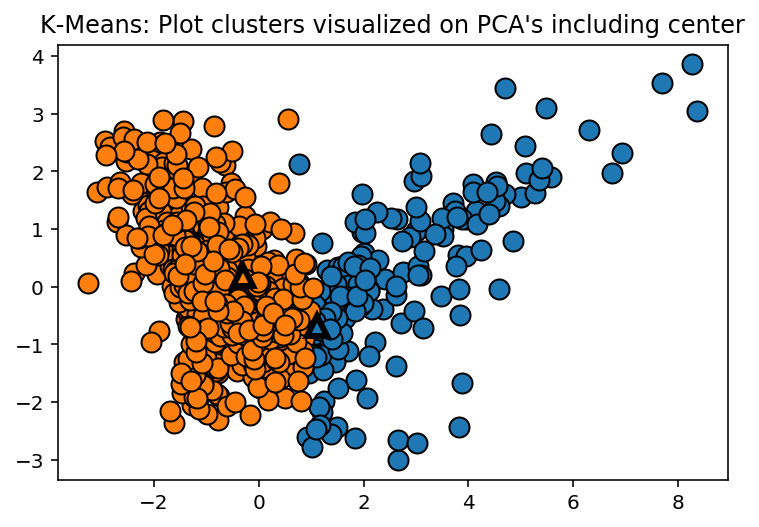

In [88]:
# visualize on PCA  
mglearn.discrete_scatter(X_pca[:, 0], X_pca[:,1], kmeans.labels_, markers='o')
mglearn.discrete_scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], [0, 1], markers='^', markeredgewidth=3)
plt.title('K-Means: Plot clusters visualized on PCA\'s including center')plt.xlabel("First principal component")
plt.ylabel("Second principal component")


ValueError: Length of values does not match length of index

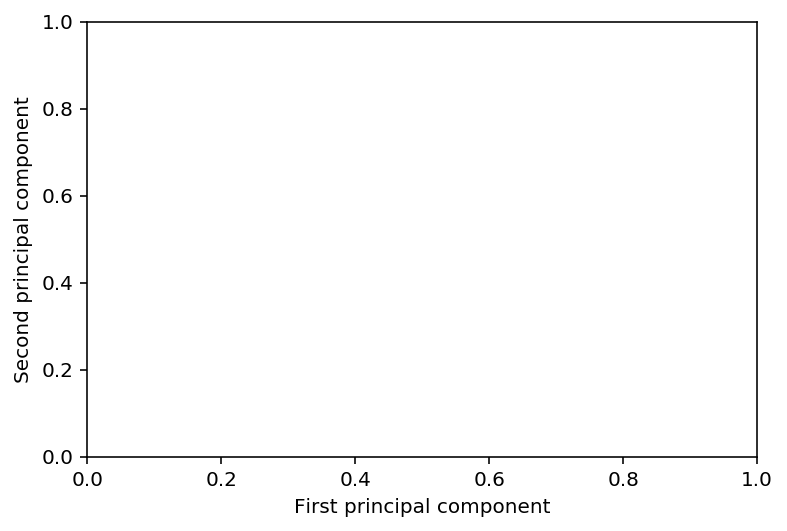

In [89]:
# STOPPED HERE, PROBLEM WITH WRITING THE LABELS BACK TO THE DATAFRAME BECAUSE \
# THE ORIGINAL HAS NAN'S AND THEREFORE THIS ONE IS SHORTER
features_df['Clusters'] = kmeans.labels_
cluster_label = kmeans.labels_

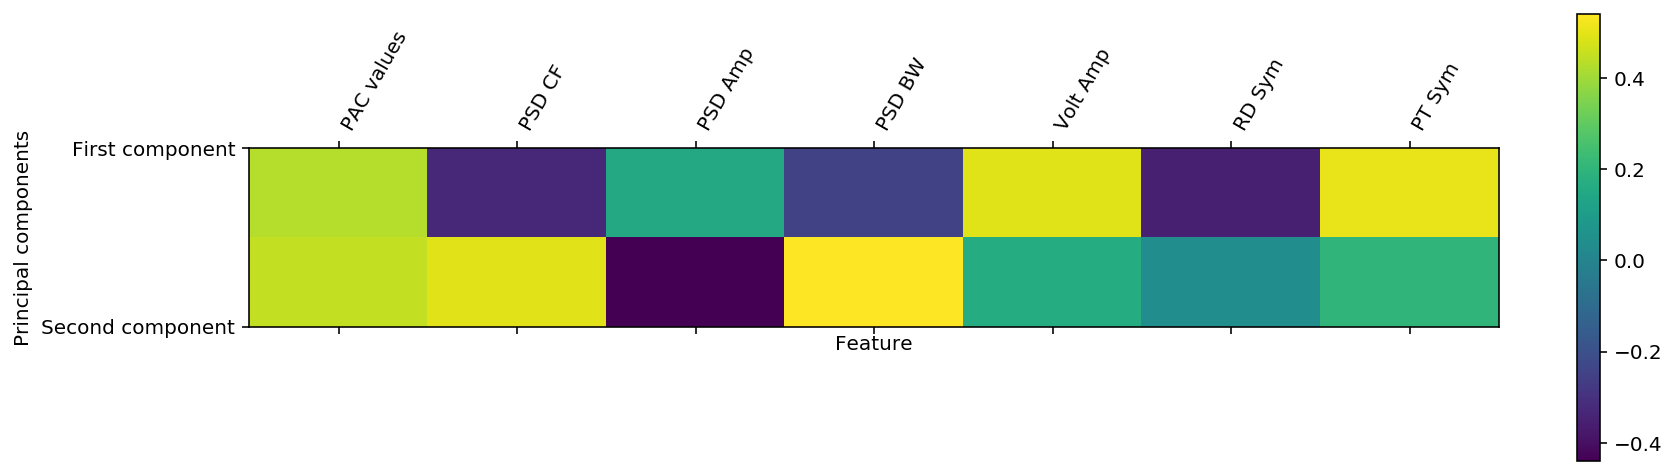

In [90]:
# Which features drive both components?
plt.matshow(pca.components_, cmap='viridis');
plt.yticks([0, 1], ["First component", "Second component"]);
plt.colorbar();
plt.xticks(range(len(feature_list)),feature_list, rotation=60, ha='left');
plt.xlabel("Feature");
plt.ylabel("Principal components");